# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask

from calc_adjustment import read_data
from apply_adjustment import check_units

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [4]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/test_space/tasmax-qqscale-factors-additive_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc"
qq_file = "/g/data/wp00/users/dbi599/test_space/tasmax-qqscaled-additive_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc"
example_lat = -42.9
example_lon = 147.3
example_month = 6
cmip_units = "K"
obs_units = "C"
qq_units = "C"
cmip_var = "tasmax"
obs_var = "tmax"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
fut_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc"
obs_files = "/g/data/xv83/agcd-csiro/tmax/daily/tmax_AGCD-CSIRO_r005_19100101-20220404_daily_space-chunked.zarr"
hist_time_bounds = "1995-01-01 2014-12-31"
fut_time_bounds = "2035-01-01 2064-12-31"
obs_time_bounds = "1990-01-01 2019-12-31"


In [5]:
# Required parameters
assert 'cmip_var' in locals(), "Must provide a CMIP variable name (option -p cmip_var {name})"
assert 'obs_var' in locals(), "Must provide a observations variable name (option -p obs_var {name})"
assert 'cmip_units' in locals(), "Must provide CMIP units name (option -p cmip_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'fut_files' in locals(), """Must provide future data files (option -p fut_files {"file paths"})"""
assert 'obs_files' in locals(), """Must provide observational data files (option -p obs_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'obs_time_bounds' in locals(), """Must provide time bounds for observations (option -p obs_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical GCM data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'fut_time_bounds' in locals(), """Must provide time bounds for future GCM data (option -p fut_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [6]:
hist_files = hist_files.split()
fut_files = fut_files.split()
obs_files = obs_files.split()

obs_time_bounds = obs_time_bounds.split()
hist_time_bounds = hist_time_bounds.split()
fut_time_bounds = fut_time_bounds.split()

## Read data

In [7]:
ds_obs = read_data(
    obs_files,
    obs_var,
    time_bounds=obs_time_bounds,
    input_units=obs_units,
    output_units=qq_units
)

/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [8]:
ds_obs[obs_var]

<xarray.DataArray 'tmax' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-tmax, shape=(10957, 691, 886), dtype=float32, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:              2018-08-16 23:45:40 UTC
    analysis_version_number:    2.01
    cell_methods:               time: maximum
    frequency:                  daily
    length_scale_for_analysis:  250.0
    long_name:                  Daily maximum air temperature
    source:                     Interpolated surface observations
    standard_name:              air_temperature
    units:                      °C

In [9]:
lat_min_obs = ds_obs['lat'].values.min()
lat_max_obs = ds_obs['lat'].values.max()
lon_min_obs = ds_obs['lon'].values.min()
lon_max_obs = ds_obs['lon'].values.max()

In [10]:
print(lat_min_obs, lat_max_obs, lon_min_obs, lon_max_obs)

-44.5 -10.0 112.0 156.25


In [11]:
ds_hist = read_data(
    hist_files,
    cmip_var,
    time_bounds=hist_time_bounds,
    input_units=cmip_units,
    output_units=qq_units)
ds_hist[cmip_var]

<xarray.DataArray 'tasmax' (time: 7305, lat: 145, lon: 192)>
dask.array<truediv, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          °C
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-11-15T17:36:46Z altered by CMOR: Treated scalar dime...

In [12]:
ds_future = read_data(
    fut_files,
    cmip_var,
    time_bounds=fut_time_bounds,
    input_units=cmip_units,
    output_units=qq_units)
ds_future[cmip_var]

<xarray.DataArray 'tasmax' (time: 10958, lat: 145, lon: 192)>
dask.array<truediv, shape=(10958, 145, 192), dtype=float32, chunksize=(10958, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2035-01-01T12:00:00 ... 2064-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          °C
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-11-15T10:38:50Z altered by CMOR: Treated scalar dime...

In [13]:
ds_adjust = xr.open_dataset(adjustment_file)
qm = sdba.QuantileDeltaMapping.from_dataset(ds_adjust)

In [14]:
qq_obs = xr.open_dataset(qq_file)

## Quantile mapping

In [15]:
def quantile_month_plot(da, cmap=None, diverging=False, point=None):
    """Create two dimensional month/quantile plot"""

    fig, ax = plt.subplots(figsize=[16, 6])
    if 'lat' in da.dims:
        point_selection = {'lat': example_lat, 'lon': example_lon}
    else:
        point_selection = {}
    quantiles = da.sel(point_selection, method='nearest')
    if diverging:
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    quantiles.transpose('month', 'quantiles').plot(cmap=cmap, vmax=vmax, vmin=vmin)
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    plt.yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    plt.show()

In [16]:
def quantile_spatial_plot(
    da, month, lat_bounds=None, lon_bounds=None, cmap=None, diverging=False,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min_obs, lat_max_obs = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min_obs, lat_max_obs))
    if lon_bounds:
        lon_min_obs, lon_max_obs = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min_obs, lon_max_obs))
    if diverging:
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        vmax=vmax,
        vmin=vmin,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

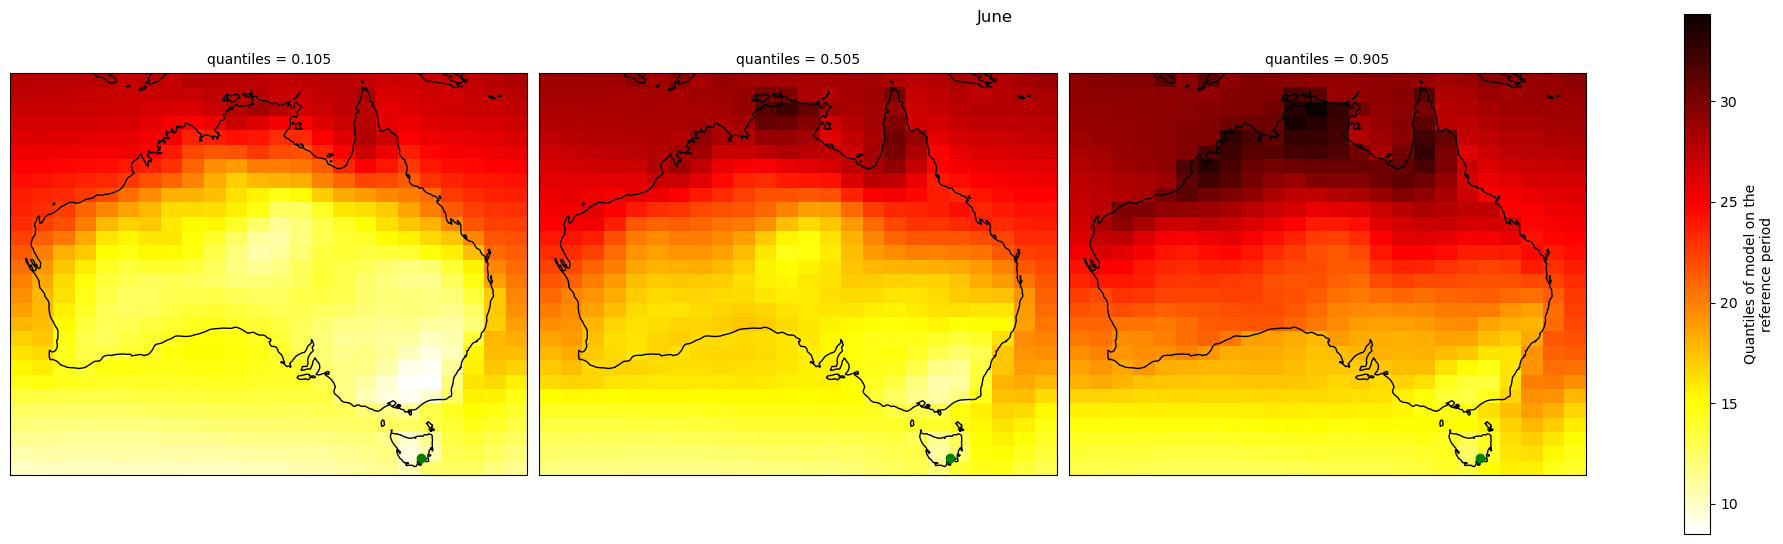

In [17]:
if 'lat' in qm.ds.dims:
    quantile_spatial_plot(
        qm.ds['hist_q'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        cmap='hot_r',
    )

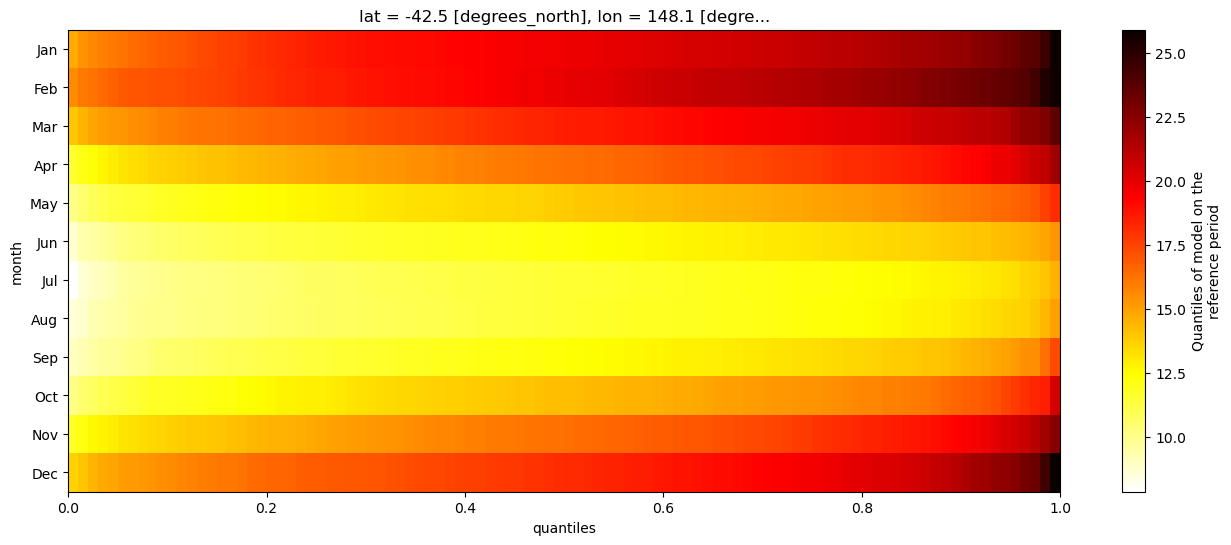

In [18]:
quantile_month_plot(qm.ds['hist_q'], cmap='hot_r')

In [19]:
qm.ds['af']

<xarray.DataArray 'af' (quantiles: 100, month: 12, lat: 145, lon: 192)>
[33408000 values with dtype=float32]
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Attributes:
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors

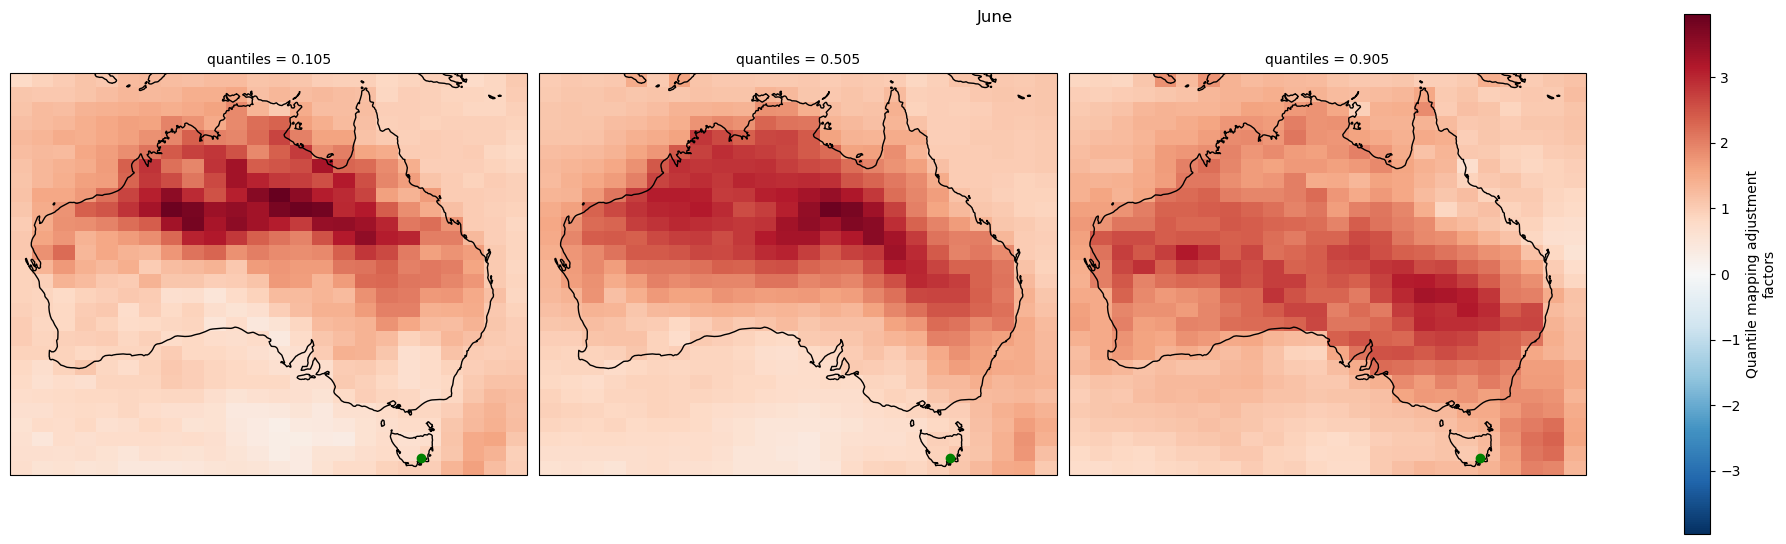

In [20]:
if 'lat' in qm.ds.dims:
    quantile_spatial_plot(
        qm.ds['af'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        cmap='RdBu_r',
        diverging=True,
    )

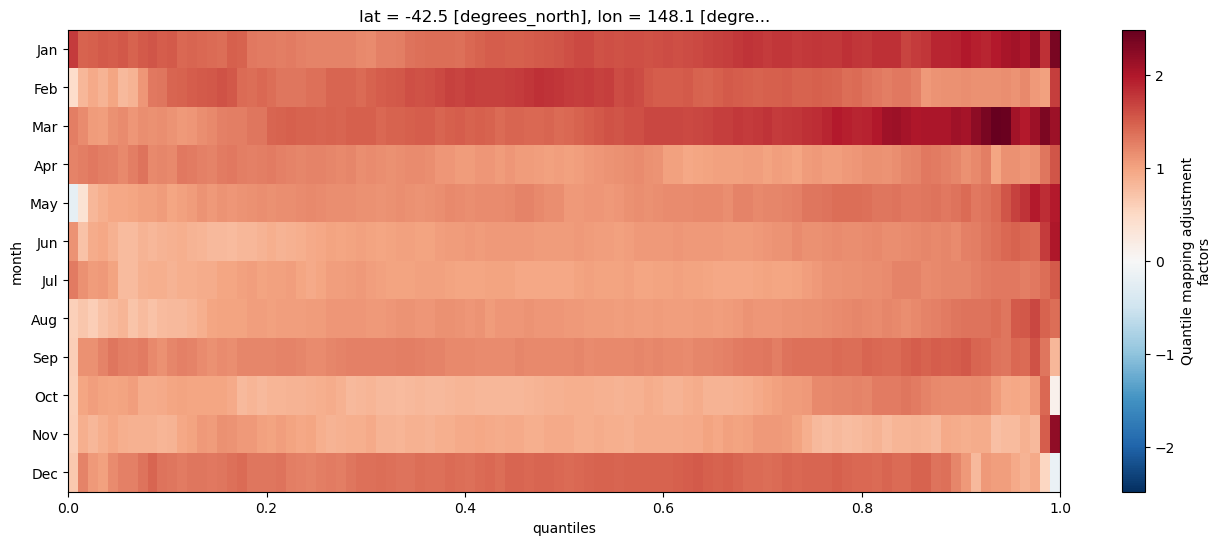

In [21]:
quantile_month_plot(qm.ds['af'], cmap='RdBu_r', diverging=True)

## QQ-scaled projections

In [22]:
model_sel = {'lat': slice(lat_min_obs, lat_max_obs), 'lon': slice(lon_min_obs, lon_max_obs)}

In [23]:
hist_clim = ds_hist[cmip_var].mean('time', keep_attrs=True)
future_clim = ds_future[cmip_var].mean('time', keep_attrs=True)
model_mean_change = future_clim - hist_clim

In [24]:
model_mean_change = model_mean_change.compute()

[                                        ] | 0% Completed | 574.12 us

[                                        ] | 0% Completed | 103.14 ms

[                                        ] | 0% Completed | 204.61 ms

[                                        ] | 0% Completed | 305.98 ms

[                                        ] | 0% Completed | 407.38 ms

[                                        ] | 0% Completed | 508.80 ms

[                                        ] | 0% Completed | 610.18 ms

[                                        ] | 0% Completed | 711.51 ms

[                                        ] | 0% Completed | 812.91 ms

[                                        ] | 0% Completed | 914.25 ms

[                                        ] | 0% Completed | 1.02 s

[                                        ] | 0% Completed | 1.12 s

[                                        ] | 0% Completed | 1.22 s

[                                        ] | 0% Completed | 1.32 s

[#######                                 ] | 18% Completed | 1.42 s

[#######                                 ] | 18% Completed | 1.52 s

[#######                                 ] | 18% Completed | 1.62 s

[#######                                 ] | 18% Completed | 1.73 s

[#######                                 ] | 18% Completed | 1.83 s

[#######                                 ] | 18% Completed | 1.93 s

[#######                                 ] | 18% Completed | 2.03 s

[#######                                 ] | 18% Completed | 2.13 s

[#######                                 ] | 18% Completed | 2.23 s

[#######                                 ] | 18% Completed | 2.33 s

[#######                                 ] | 18% Completed | 2.44 s

[#######                                 ] | 18% Completed | 2.54 s

[#######                                 ] | 18% Completed | 2.64 s

[#######                                 ] | 18% Completed | 2.74 s

[#######                                 ] | 18% Completed | 2.84 s

[#######                                 ] | 18% Completed | 2.94 s

[#######                                 ] | 18% Completed | 3.04 s

[#######                                 ] | 18% Completed | 3.14 s

[#######                                 ] | 18% Completed | 3.25 s

[#######                                 ] | 18% Completed | 3.35 s

[#######                                 ] | 18% Completed | 3.45 s

[#######                                 ] | 18% Completed | 3.55 s

[#######                                 ] | 18% Completed | 3.65 s

[#######                                 ] | 18% Completed | 3.75 s

[#######                                 ] | 18% Completed | 3.85 s

[#######                                 ] | 18% Completed | 3.96 s

[#######                                 ] | 18% Completed | 4.06 s

[#######                                 ] | 18% Completed | 4.16 s

[#######                                 ] | 18% Completed | 4.26 s

[#######                                 ] | 18% Completed | 4.36 s

[#######                                 ] | 18% Completed | 4.46 s

[#######                                 ] | 18% Completed | 4.56 s

[#######                                 ] | 18% Completed | 4.67 s

[#######                                 ] | 18% Completed | 4.77 s

[#######                                 ] | 18% Completed | 4.87 s

[#######                                 ] | 18% Completed | 4.97 s

[#######                                 ] | 18% Completed | 5.07 s

[#######                                 ] | 18% Completed | 5.17 s

[#######                                 ] | 18% Completed | 5.27 s

[##############                          ] | 36% Completed | 5.38 s

[##############                          ] | 36% Completed | 5.48 s

[##############                          ] | 36% Completed | 5.58 s

[##############                          ] | 36% Completed | 5.68 s

[##############                          ] | 36% Completed | 5.78 s

[##############                          ] | 36% Completed | 5.88 s

[##############                          ] | 36% Completed | 5.98 s

[##############                          ] | 36% Completed | 6.09 s

[##############                          ] | 36% Completed | 6.19 s

[##############                          ] | 36% Completed | 6.29 s

[##############                          ] | 36% Completed | 6.39 s

[##############                          ] | 36% Completed | 6.49 s

[#####################                   ] | 54% Completed | 6.59 s

[#####################                   ] | 54% Completed | 6.69 s

[#####################                   ] | 54% Completed | 6.79 s

[#####################                   ] | 54% Completed | 6.90 s

[#####################                   ] | 54% Completed | 7.00 s

[#####################                   ] | 54% Completed | 7.10 s

[#####################                   ] | 54% Completed | 7.20 s

[#####################                   ] | 54% Completed | 7.30 s

[#####################                   ] | 54% Completed | 7.40 s

[#####################                   ] | 54% Completed | 7.51 s

[#####################                   ] | 54% Completed | 7.61 s

[#####################                   ] | 54% Completed | 7.71 s

[#####################                   ] | 54% Completed | 7.81 s

[#####################                   ] | 54% Completed | 7.91 s

[#####################                   ] | 54% Completed | 8.01 s

[#####################                   ] | 54% Completed | 8.11 s

[#####################                   ] | 54% Completed | 8.21 s

[#####################                   ] | 54% Completed | 8.32 s

[#####################                   ] | 54% Completed | 8.42 s

[#####################                   ] | 54% Completed | 8.52 s

[#####################                   ] | 54% Completed | 8.62 s

[#####################                   ] | 54% Completed | 8.72 s

[#####################                   ] | 54% Completed | 8.82 s

[#####################                   ] | 54% Completed | 8.92 s

[#####################                   ] | 54% Completed | 9.03 s

[#####################                   ] | 54% Completed | 9.13 s

[#####################                   ] | 54% Completed | 9.23 s

[#####################                   ] | 54% Completed | 9.33 s

[#####################                   ] | 54% Completed | 9.43 s

[#####################                   ] | 54% Completed | 9.53 s

[#####################                   ] | 54% Completed | 9.64 s

[#####################                   ] | 54% Completed | 9.74 s

[#####################                   ] | 54% Completed | 9.84 s

[#####################                   ] | 54% Completed | 9.94 s

[#####################                   ] | 54% Completed | 10.04 s

[#####################                   ] | 54% Completed | 10.14 s

[#####################                   ] | 54% Completed | 10.24 s

[#####################                   ] | 54% Completed | 10.35 s

[#####################                   ] | 54% Completed | 10.45 s

[#####################                   ] | 54% Completed | 10.55 s

[#####################                   ] | 54% Completed | 10.65 s

[#####################                   ] | 54% Completed | 10.75 s

[#####################                   ] | 54% Completed | 10.85 s

[#####################                   ] | 54% Completed | 10.95 s

[#####################                   ] | 54% Completed | 11.06 s

[#####################                   ] | 54% Completed | 11.16 s

[#####################                   ] | 54% Completed | 11.26 s

[#####################                   ] | 54% Completed | 11.36 s

[#####################                   ] | 54% Completed | 11.46 s

[#####################                   ] | 54% Completed | 11.56 s

[#####################                   ] | 54% Completed | 11.66 s

[#####################                   ] | 54% Completed | 11.77 s

[#####################                   ] | 54% Completed | 11.87 s

[#####################                   ] | 54% Completed | 11.97 s

[#####################                   ] | 54% Completed | 12.07 s

[#####################                   ] | 54% Completed | 12.17 s

[#####################                   ] | 54% Completed | 12.27 s

[#####################                   ] | 54% Completed | 12.37 s

[#####################                   ] | 54% Completed | 12.48 s

[#####################                   ] | 54% Completed | 12.58 s

[#####################                   ] | 54% Completed | 12.68 s

[#####################                   ] | 54% Completed | 12.78 s

[#####################                   ] | 54% Completed | 12.88 s

[#####################                   ] | 54% Completed | 12.98 s

[#############################           ] | 72% Completed | 13.08 s

[#############################           ] | 72% Completed | 13.19 s

[#############################           ] | 72% Completed | 13.29 s

[#############################           ] | 72% Completed | 13.39 s

[#############################           ] | 72% Completed | 13.49 s

[#############################           ] | 72% Completed | 13.59 s

[#############################           ] | 72% Completed | 13.69 s

[#############################           ] | 72% Completed | 13.79 s

[#############################           ] | 72% Completed | 13.90 s

[#############################           ] | 72% Completed | 14.00 s

[#############################           ] | 72% Completed | 14.10 s

[#############################           ] | 72% Completed | 14.20 s

[#############################           ] | 72% Completed | 14.30 s

[#############################           ] | 72% Completed | 14.40 s

[########################################] | 100% Completed | 14.50 s

In [25]:
obs_clim = ds_obs[obs_var].mean('time', keep_attrs=True)
qq_clim = qq_obs[obs_var].mean('time', keep_attrs=True)
qq_mean_change = qq_clim - obs_clim

In [26]:
qq_mean_change = qq_mean_change.compute()

[                                        ] | 0% Completed | 426.20 us

[                                        ] | 0% Completed | 102.61 ms

[                                        ] | 0% Completed | 204.04 ms

[                                        ] | 0% Completed | 305.39 ms

[                                        ] | 0% Completed | 406.76 ms

[                                        ] | 0% Completed | 508.11 ms

[                                        ] | 0% Completed | 609.48 ms

[                                        ] | 0% Completed | 710.86 ms

[                                        ] | 0% Completed | 812.23 ms

[                                        ] | 0% Completed | 913.60 ms

[                                        ] | 0% Completed | 1.01 s

[                                        ] | 0% Completed | 1.12 s

[                                        ] | 0% Completed | 1.22 s

[                                        ] | 0% Completed | 1.32 s

[                                        ] | 0% Completed | 1.42 s

[                                        ] | 0% Completed | 1.52 s

[                                        ] | 0% Completed | 1.62 s

[                                        ] | 0% Completed | 1.72 s

[                                        ] | 0% Completed | 1.83 s

[                                        ] | 0% Completed | 1.93 s

[                                        ] | 0% Completed | 2.03 s

[                                        ] | 0% Completed | 2.13 s

[                                        ] | 0% Completed | 2.23 s

[                                        ] | 0% Completed | 2.33 s

[                                        ] | 0% Completed | 2.43 s

[                                        ] | 0% Completed | 2.54 s

[                                        ] | 0% Completed | 2.64 s

[                                        ] | 0% Completed | 2.74 s

[                                        ] | 0% Completed | 2.84 s

[                                        ] | 0% Completed | 2.94 s

[                                        ] | 0% Completed | 3.04 s

[                                        ] | 0% Completed | 3.14 s

[                                        ] | 0% Completed | 3.24 s

[                                        ] | 0% Completed | 3.35 s

[                                        ] | 0% Completed | 3.45 s

[                                        ] | 0% Completed | 3.55 s

[                                        ] | 0% Completed | 3.65 s

[                                        ] | 0% Completed | 3.75 s

[                                        ] | 0% Completed | 3.85 s

[                                        ] | 0% Completed | 3.95 s

[                                        ] | 0% Completed | 4.06 s

[                                        ] | 0% Completed | 4.16 s

[                                        ] | 0% Completed | 4.26 s

[                                        ] | 0% Completed | 4.36 s

[                                        ] | 0% Completed | 4.46 s

[                                        ] | 0% Completed | 4.56 s

[                                        ] | 0% Completed | 4.66 s

[                                        ] | 0% Completed | 4.77 s

[                                        ] | 0% Completed | 4.87 s

[                                        ] | 0% Completed | 4.97 s

[                                        ] | 0% Completed | 5.07 s

[                                        ] | 0% Completed | 5.17 s

[                                        ] | 0% Completed | 5.27 s

[                                        ] | 0% Completed | 5.37 s

[                                        ] | 0% Completed | 5.48 s

[                                        ] | 0% Completed | 5.58 s

[                                        ] | 0% Completed | 5.68 s

[                                        ] | 0% Completed | 5.78 s

[                                        ] | 0% Completed | 5.88 s

[                                        ] | 0% Completed | 5.98 s

[                                        ] | 0% Completed | 6.08 s

[                                        ] | 0% Completed | 6.19 s

[                                        ] | 0% Completed | 6.29 s

[                                        ] | 0% Completed | 6.39 s

[                                        ] | 0% Completed | 6.49 s

[                                        ] | 0% Completed | 6.59 s

[                                        ] | 0% Completed | 6.69 s

[                                        ] | 0% Completed | 6.80 s

[                                        ] | 0% Completed | 6.90 s

[                                        ] | 0% Completed | 7.00 s

[                                        ] | 0% Completed | 7.10 s

[                                        ] | 0% Completed | 7.20 s

[                                        ] | 0% Completed | 7.30 s

[                                        ] | 0% Completed | 7.40 s

[                                        ] | 0% Completed | 7.51 s

[                                        ] | 0% Completed | 7.61 s

[                                        ] | 0% Completed | 7.71 s

[                                        ] | 0% Completed | 7.81 s

[                                        ] | 0% Completed | 7.91 s

[                                        ] | 0% Completed | 8.01 s

[                                        ] | 0% Completed | 8.12 s

[                                        ] | 0% Completed | 8.22 s

[                                        ] | 0% Completed | 8.32 s

[                                        ] | 0% Completed | 8.42 s

[                                        ] | 0% Completed | 8.52 s

[                                        ] | 0% Completed | 8.62 s

[                                        ] | 0% Completed | 8.72 s

[                                        ] | 0% Completed | 8.83 s

[                                        ] | 0% Completed | 8.93 s

[                                        ] | 0% Completed | 9.03 s

[                                        ] | 0% Completed | 9.13 s

[                                        ] | 0% Completed | 9.23 s

[                                        ] | 0% Completed | 9.33 s

[                                        ] | 0% Completed | 9.43 s

[                                        ] | 0% Completed | 9.54 s

[                                        ] | 0% Completed | 9.64 s

[                                        ] | 0% Completed | 9.74 s

[                                        ] | 0% Completed | 9.84 s

[                                        ] | 0% Completed | 9.94 s

[                                        ] | 0% Completed | 10.04 s

[                                        ] | 0% Completed | 10.14 s

[                                        ] | 0% Completed | 10.25 s

[                                        ] | 0% Completed | 10.35 s

[                                        ] | 0% Completed | 10.45 s

[                                        ] | 0% Completed | 10.55 s

[                                        ] | 0% Completed | 10.65 s

[                                        ] | 0% Completed | 10.75 s

[                                        ] | 0% Completed | 10.85 s

[                                        ] | 0% Completed | 10.96 s

[                                        ] | 0% Completed | 11.06 s

[                                        ] | 0% Completed | 11.16 s

[                                        ] | 0% Completed | 11.26 s

[                                        ] | 0% Completed | 11.36 s

[                                        ] | 0% Completed | 11.46 s

[                                        ] | 0% Completed | 11.56 s

[                                        ] | 0% Completed | 11.67 s

[                                        ] | 0% Completed | 11.77 s

[                                        ] | 0% Completed | 11.87 s

[                                        ] | 0% Completed | 11.97 s

[                                        ] | 0% Completed | 12.07 s

[                                        ] | 0% Completed | 12.17 s

[                                        ] | 0% Completed | 12.27 s

[                                        ] | 0% Completed | 12.38 s

[                                        ] | 0% Completed | 12.48 s

[                                        ] | 0% Completed | 12.58 s

[                                        ] | 0% Completed | 12.68 s

[                                        ] | 0% Completed | 12.78 s

[                                        ] | 0% Completed | 12.88 s

[                                        ] | 0% Completed | 12.98 s

[                                        ] | 0% Completed | 13.08 s

[                                        ] | 0% Completed | 13.19 s

[                                        ] | 0% Completed | 13.29 s

[                                        ] | 0% Completed | 13.39 s

[                                        ] | 0% Completed | 13.49 s

[                                        ] | 0% Completed | 13.59 s

[                                        ] | 0% Completed | 13.69 s

[                                        ] | 0% Completed | 13.79 s

[                                        ] | 0% Completed | 13.90 s

[                                        ] | 0% Completed | 14.00 s

[                                        ] | 0% Completed | 14.10 s

[                                        ] | 0% Completed | 14.20 s

[                                        ] | 0% Completed | 14.30 s

[                                        ] | 0% Completed | 14.40 s

[                                        ] | 0% Completed | 14.50 s

[                                        ] | 0% Completed | 14.61 s

[                                        ] | 0% Completed | 14.71 s

[                                        ] | 0% Completed | 14.81 s

[                                        ] | 0% Completed | 14.91 s

[                                        ] | 0% Completed | 15.01 s

[                                        ] | 0% Completed | 15.11 s

[                                        ] | 0% Completed | 15.21 s

[                                        ] | 0% Completed | 15.32 s

[                                        ] | 0% Completed | 15.42 s

[                                        ] | 0% Completed | 15.52 s

[                                        ] | 0% Completed | 15.62 s

[                                        ] | 0% Completed | 15.72 s

[                                        ] | 0% Completed | 15.82 s

[                                        ] | 0% Completed | 15.92 s

[                                        ] | 0% Completed | 16.03 s

[                                        ] | 0% Completed | 16.13 s

[                                        ] | 0% Completed | 16.23 s

[                                        ] | 0% Completed | 16.33 s

[                                        ] | 0% Completed | 16.43 s

[                                        ] | 0% Completed | 16.53 s

[                                        ] | 0% Completed | 16.63 s

[                                        ] | 0% Completed | 16.74 s

[                                        ] | 0% Completed | 16.84 s

[                                        ] | 0% Completed | 16.94 s

[                                        ] | 0% Completed | 17.04 s

[                                        ] | 0% Completed | 17.14 s

[                                        ] | 0% Completed | 17.24 s

[                                        ] | 0% Completed | 17.34 s

[                                        ] | 0% Completed | 17.45 s

[                                        ] | 0% Completed | 17.55 s

[                                        ] | 0% Completed | 17.65 s

[                                        ] | 0% Completed | 17.75 s

[                                        ] | 0% Completed | 17.85 s

[                                        ] | 0% Completed | 17.95 s

[                                        ] | 0% Completed | 18.05 s

[                                        ] | 0% Completed | 18.15 s

[                                        ] | 0% Completed | 18.26 s

[                                        ] | 0% Completed | 18.36 s

[                                        ] | 0% Completed | 18.46 s

[                                        ] | 0% Completed | 18.56 s

[                                        ] | 0% Completed | 18.66 s

[                                        ] | 0% Completed | 18.76 s

[                                        ] | 0% Completed | 18.86 s

[                                        ] | 0% Completed | 18.97 s

[                                        ] | 0% Completed | 19.07 s

[                                        ] | 0% Completed | 19.17 s

[                                        ] | 0% Completed | 19.27 s

[                                        ] | 0% Completed | 19.37 s

[                                        ] | 0% Completed | 19.47 s

[                                        ] | 0% Completed | 19.57 s

[                                        ] | 0% Completed | 19.68 s

[                                        ] | 0% Completed | 19.78 s

[                                        ] | 0% Completed | 19.88 s

[                                        ] | 0% Completed | 19.98 s

[                                        ] | 0% Completed | 20.08 s

[                                        ] | 0% Completed | 20.18 s

[                                        ] | 0% Completed | 20.28 s

[                                        ] | 0% Completed | 20.39 s

[                                        ] | 0% Completed | 20.49 s

[                                        ] | 0% Completed | 20.59 s

[                                        ] | 0% Completed | 20.69 s

[                                        ] | 0% Completed | 20.79 s

[                                        ] | 0% Completed | 20.89 s

[                                        ] | 0% Completed | 20.99 s

[                                        ] | 0% Completed | 21.10 s

[                                        ] | 0% Completed | 21.20 s

[                                        ] | 0% Completed | 21.30 s

[                                        ] | 0% Completed | 21.40 s

[                                        ] | 0% Completed | 21.50 s

[                                        ] | 0% Completed | 21.60 s

[                                        ] | 0% Completed | 21.70 s

[                                        ] | 0% Completed | 21.81 s

[                                        ] | 0% Completed | 21.91 s

[                                        ] | 0% Completed | 22.01 s

[                                        ] | 0% Completed | 22.11 s

[                                        ] | 0% Completed | 22.21 s

[                                        ] | 0% Completed | 22.31 s

[                                        ] | 0% Completed | 22.41 s

[                                        ] | 0% Completed | 22.52 s

[                                        ] | 0% Completed | 22.62 s

[                                        ] | 0% Completed | 22.72 s

[                                        ] | 0% Completed | 22.82 s

[                                        ] | 0% Completed | 22.92 s

[                                        ] | 0% Completed | 23.02 s

[                                        ] | 0% Completed | 23.12 s

[                                        ] | 0% Completed | 23.23 s

[                                        ] | 0% Completed | 23.33 s

[                                        ] | 0% Completed | 23.43 s

[                                        ] | 0% Completed | 23.53 s

[                                        ] | 0% Completed | 23.63 s

[                                        ] | 0% Completed | 23.73 s

[                                        ] | 0% Completed | 23.83 s

[                                        ] | 0% Completed | 23.93 s

[                                        ] | 0% Completed | 24.04 s

[                                        ] | 0% Completed | 24.14 s

[                                        ] | 0% Completed | 24.24 s

[                                        ] | 0% Completed | 24.34 s

[                                        ] | 0% Completed | 24.44 s

[                                        ] | 0% Completed | 24.54 s

[                                        ] | 0% Completed | 24.64 s

[                                        ] | 0% Completed | 24.75 s

[                                        ] | 0% Completed | 24.85 s

[                                        ] | 0% Completed | 24.95 s

[                                        ] | 0% Completed | 25.05 s

[                                        ] | 0% Completed | 25.15 s

[                                        ] | 0% Completed | 25.25 s

[                                        ] | 0% Completed | 25.35 s

[                                        ] | 0% Completed | 25.46 s

[                                        ] | 0% Completed | 25.56 s

[                                        ] | 0% Completed | 25.66 s

[                                        ] | 0% Completed | 25.76 s

[                                        ] | 0% Completed | 25.86 s

[                                        ] | 0% Completed | 25.96 s

[                                        ] | 0% Completed | 26.06 s

[                                        ] | 0% Completed | 26.17 s

[                                        ] | 0% Completed | 26.27 s

[                                        ] | 0% Completed | 26.37 s

[                                        ] | 0% Completed | 26.47 s

[                                        ] | 0% Completed | 26.57 s

[                                        ] | 0% Completed | 26.67 s

[                                        ] | 0% Completed | 26.77 s

[                                        ] | 0% Completed | 26.88 s

[                                        ] | 0% Completed | 26.98 s

[                                        ] | 0% Completed | 27.08 s

[                                        ] | 0% Completed | 27.18 s

[                                        ] | 0% Completed | 27.28 s

[                                        ] | 0% Completed | 27.38 s

[                                        ] | 0% Completed | 27.48 s

[                                        ] | 0% Completed | 27.59 s

[                                        ] | 0% Completed | 27.69 s

[                                        ] | 0% Completed | 27.79 s

[                                        ] | 0% Completed | 27.89 s

[                                        ] | 0% Completed | 27.99 s

[                                        ] | 0% Completed | 28.09 s

[                                        ] | 0% Completed | 28.19 s

[                                        ] | 0% Completed | 28.30 s

[                                        ] | 0% Completed | 28.40 s

[                                        ] | 0% Completed | 28.50 s

[                                        ] | 0% Completed | 28.60 s

[                                        ] | 0% Completed | 28.70 s

[                                        ] | 0% Completed | 28.80 s

[                                        ] | 0% Completed | 28.90 s

[                                        ] | 0% Completed | 29.01 s

[                                        ] | 0% Completed | 29.11 s

[                                        ] | 0% Completed | 29.21 s

[                                        ] | 0% Completed | 29.31 s

[                                        ] | 0% Completed | 29.41 s

[                                        ] | 0% Completed | 29.51 s

[                                        ] | 0% Completed | 29.61 s

[                                        ] | 0% Completed | 29.72 s

[                                        ] | 0% Completed | 29.82 s

[                                        ] | 0% Completed | 29.92 s

[                                        ] | 0% Completed | 30.02 s

[                                        ] | 0% Completed | 30.12 s

[                                        ] | 0% Completed | 30.22 s

[                                        ] | 0% Completed | 30.32 s

[                                        ] | 0% Completed | 30.43 s

[                                        ] | 0% Completed | 30.53 s

[                                        ] | 0% Completed | 30.63 s

[                                        ] | 0% Completed | 30.73 s

[                                        ] | 0% Completed | 30.83 s

[                                        ] | 0% Completed | 30.93 s

[                                        ] | 0% Completed | 31.03 s

[                                        ] | 0% Completed | 31.13 s

[                                        ] | 0% Completed | 31.24 s

[                                        ] | 0% Completed | 31.34 s

[                                        ] | 0% Completed | 31.44 s

[                                        ] | 0% Completed | 31.54 s

[                                        ] | 0% Completed | 31.64 s

[                                        ] | 0% Completed | 31.74 s

[                                        ] | 0% Completed | 31.84 s

[                                        ] | 0% Completed | 31.95 s

[                                        ] | 0% Completed | 32.05 s

[                                        ] | 0% Completed | 32.15 s

[                                        ] | 0% Completed | 32.25 s

[                                        ] | 0% Completed | 32.35 s

[                                        ] | 0% Completed | 32.45 s

[                                        ] | 0% Completed | 32.55 s

[                                        ] | 0% Completed | 32.66 s

[                                        ] | 0% Completed | 32.76 s

[                                        ] | 0% Completed | 32.86 s

[                                        ] | 0% Completed | 32.96 s

[                                        ] | 0% Completed | 33.06 s

[                                        ] | 0% Completed | 33.16 s

[                                        ] | 0% Completed | 33.26 s

[                                        ] | 0% Completed | 33.37 s

[                                        ] | 0% Completed | 33.47 s

[                                        ] | 0% Completed | 33.57 s

[                                        ] | 0% Completed | 33.67 s

[                                        ] | 0% Completed | 33.77 s

[                                        ] | 0% Completed | 33.87 s

[                                        ] | 0% Completed | 33.97 s

[                                        ] | 0% Completed | 34.08 s

[                                        ] | 0% Completed | 34.18 s

[                                        ] | 0% Completed | 34.28 s

[                                        ] | 0% Completed | 34.38 s

[                                        ] | 0% Completed | 34.48 s

[                                        ] | 0% Completed | 34.58 s

[                                        ] | 0% Completed | 34.68 s

[                                        ] | 0% Completed | 34.78 s

[                                        ] | 0% Completed | 34.89 s

[                                        ] | 0% Completed | 34.99 s

[                                        ] | 0% Completed | 35.09 s

[                                        ] | 0% Completed | 35.19 s

[                                        ] | 0% Completed | 35.29 s

[                                        ] | 0% Completed | 35.39 s

[                                        ] | 0% Completed | 35.49 s

[                                        ] | 0% Completed | 35.60 s

[                                        ] | 0% Completed | 35.70 s

[                                        ] | 0% Completed | 35.80 s

[                                        ] | 0% Completed | 35.90 s

[                                        ] | 0% Completed | 36.00 s

[                                        ] | 0% Completed | 36.10 s

[                                        ] | 0% Completed | 36.20 s

[                                        ] | 0% Completed | 36.31 s

[                                        ] | 0% Completed | 36.41 s

[                                        ] | 0% Completed | 36.51 s

[                                        ] | 0% Completed | 36.61 s

[                                        ] | 0% Completed | 36.71 s

[                                        ] | 0% Completed | 36.81 s

[                                        ] | 0% Completed | 36.91 s

[                                        ] | 0% Completed | 37.02 s

[                                        ] | 0% Completed | 37.12 s

[                                        ] | 0% Completed | 37.22 s

[                                        ] | 0% Completed | 37.32 s

[                                        ] | 0% Completed | 37.42 s

[                                        ] | 0% Completed | 37.52 s

[                                        ] | 0% Completed | 37.62 s

[                                        ] | 0% Completed | 37.73 s

[                                        ] | 0% Completed | 37.83 s

[                                        ] | 0% Completed | 37.93 s

[                                        ] | 0% Completed | 38.03 s

[                                        ] | 0% Completed | 38.13 s

[                                        ] | 0% Completed | 38.23 s

[                                        ] | 0% Completed | 38.33 s

[                                        ] | 0% Completed | 38.44 s

[                                        ] | 0% Completed | 38.54 s

[                                        ] | 0% Completed | 38.64 s

[                                        ] | 0% Completed | 38.74 s

[                                        ] | 0% Completed | 38.84 s

[                                        ] | 0% Completed | 38.94 s

[                                        ] | 0% Completed | 39.04 s

[                                        ] | 0% Completed | 39.14 s

[                                        ] | 0% Completed | 39.25 s

[                                        ] | 0% Completed | 39.35 s

[                                        ] | 0% Completed | 39.45 s

[                                        ] | 0% Completed | 39.55 s

[                                        ] | 0% Completed | 39.65 s

[                                        ] | 0% Completed | 39.75 s

[                                        ] | 0% Completed | 39.85 s

[                                        ] | 0% Completed | 39.96 s

[                                        ] | 0% Completed | 40.06 s

[                                        ] | 0% Completed | 40.16 s

[                                        ] | 0% Completed | 40.26 s

[                                        ] | 0% Completed | 40.36 s

[                                        ] | 0% Completed | 40.46 s

[                                        ] | 0% Completed | 40.56 s

[                                        ] | 0% Completed | 40.67 s

[                                        ] | 0% Completed | 40.77 s

[                                        ] | 0% Completed | 40.87 s

[                                        ] | 0% Completed | 40.97 s

[                                        ] | 0% Completed | 41.07 s

[                                        ] | 0% Completed | 41.17 s

[                                        ] | 0% Completed | 41.27 s

[                                        ] | 0% Completed | 41.38 s

[                                        ] | 0% Completed | 41.48 s

[                                        ] | 0% Completed | 41.58 s

[                                        ] | 0% Completed | 41.68 s

[                                        ] | 0% Completed | 41.78 s

[                                        ] | 0% Completed | 41.88 s

[                                        ] | 0% Completed | 41.98 s

[                                        ] | 0% Completed | 42.09 s

[                                        ] | 0% Completed | 42.19 s

[                                        ] | 0% Completed | 42.29 s

[                                        ] | 0% Completed | 42.39 s

[                                        ] | 0% Completed | 42.49 s

[                                        ] | 0% Completed | 42.59 s

[                                        ] | 0% Completed | 42.69 s

[                                        ] | 0% Completed | 42.80 s

[                                        ] | 0% Completed | 42.90 s

[                                        ] | 0% Completed | 43.00 s

[                                        ] | 0% Completed | 43.10 s

[                                        ] | 0% Completed | 43.20 s

[                                        ] | 0% Completed | 43.30 s

[                                        ] | 0% Completed | 43.40 s

[                                        ] | 0% Completed | 43.51 s

[                                        ] | 0% Completed | 43.61 s

[                                        ] | 0% Completed | 43.71 s

[                                        ] | 0% Completed | 43.81 s

[                                        ] | 0% Completed | 43.91 s

[                                        ] | 0% Completed | 44.01 s

[                                        ] | 0% Completed | 44.11 s

[                                        ] | 0% Completed | 44.21 s

[                                        ] | 0% Completed | 44.32 s

[                                        ] | 0% Completed | 44.42 s

[                                        ] | 0% Completed | 44.52 s

[                                        ] | 0% Completed | 44.62 s

[                                        ] | 0% Completed | 44.72 s

[                                        ] | 0% Completed | 44.82 s

[                                        ] | 0% Completed | 44.92 s

[                                        ] | 0% Completed | 45.03 s

[                                        ] | 0% Completed | 45.13 s

[                                        ] | 0% Completed | 45.23 s

[                                        ] | 0% Completed | 45.33 s

[                                        ] | 0% Completed | 45.43 s

[                                        ] | 0% Completed | 45.53 s

[                                        ] | 0% Completed | 45.63 s

[                                        ] | 0% Completed | 45.74 s

[                                        ] | 0% Completed | 45.84 s

[                                        ] | 0% Completed | 45.94 s

[                                        ] | 0% Completed | 46.04 s

[                                        ] | 0% Completed | 46.14 s

[                                        ] | 0% Completed | 46.24 s

[                                        ] | 0% Completed | 46.34 s

[                                        ] | 0% Completed | 46.45 s

[                                        ] | 0% Completed | 46.55 s

[                                        ] | 0% Completed | 46.65 s

[                                        ] | 0% Completed | 46.75 s

[                                        ] | 0% Completed | 46.85 s

[                                        ] | 0% Completed | 46.95 s

[                                        ] | 0% Completed | 47.05 s

[                                        ] | 0% Completed | 47.15 s

[                                        ] | 0% Completed | 47.26 s

[                                        ] | 0% Completed | 47.36 s

[                                        ] | 0% Completed | 47.46 s

[                                        ] | 0% Completed | 47.56 s

[                                        ] | 0% Completed | 47.66 s

[                                        ] | 0% Completed | 47.76 s

[                                        ] | 0% Completed | 47.86 s

[                                        ] | 0% Completed | 47.97 s

[                                        ] | 0% Completed | 48.07 s

[                                        ] | 0% Completed | 48.17 s

[                                        ] | 0% Completed | 48.27 s

[                                        ] | 0% Completed | 48.37 s

[                                        ] | 0% Completed | 48.47 s

[                                        ] | 0% Completed | 48.57 s

[                                        ] | 0% Completed | 48.68 s

[                                        ] | 0% Completed | 48.78 s

[                                        ] | 0% Completed | 48.88 s

[                                        ] | 0% Completed | 48.98 s

[                                        ] | 0% Completed | 49.08 s

[                                        ] | 0% Completed | 49.18 s

[                                        ] | 0% Completed | 49.28 s

[                                        ] | 0% Completed | 49.39 s

[                                        ] | 0% Completed | 49.49 s

[                                        ] | 0% Completed | 49.59 s

[                                        ] | 0% Completed | 49.69 s

[                                        ] | 0% Completed | 49.79 s

[                                        ] | 0% Completed | 49.89 s

[                                        ] | 0% Completed | 49.99 s

[                                        ] | 0% Completed | 50.10 s

[                                        ] | 0% Completed | 50.20 s

[                                        ] | 0% Completed | 50.30 s

[                                        ] | 0% Completed | 50.40 s

[                                        ] | 0% Completed | 50.50 s

[                                        ] | 0% Completed | 50.60 s

[                                        ] | 0% Completed | 50.70 s

[                                        ] | 0% Completed | 50.80 s

[                                        ] | 0% Completed | 50.91 s

[                                        ] | 0% Completed | 51.01 s

[                                        ] | 0% Completed | 51.11 s

[                                        ] | 0% Completed | 51.21 s

[                                        ] | 0% Completed | 51.31 s

[                                        ] | 0% Completed | 51.41 s

[                                        ] | 0% Completed | 51.51 s

[                                        ] | 0% Completed | 51.62 s

[                                        ] | 0% Completed | 51.72 s

[                                        ] | 0% Completed | 51.82 s

[                                        ] | 0% Completed | 51.92 s

[                                        ] | 0% Completed | 52.02 s

[                                        ] | 0% Completed | 52.12 s

[                                        ] | 0% Completed | 52.22 s

[                                        ] | 0% Completed | 52.33 s

[                                        ] | 0% Completed | 52.43 s

[                                        ] | 0% Completed | 52.53 s

[                                        ] | 0% Completed | 52.63 s

[                                        ] | 0% Completed | 52.73 s

[                                        ] | 0% Completed | 52.83 s

[                                        ] | 0% Completed | 52.93 s

[                                        ] | 0% Completed | 53.04 s

[                                        ] | 0% Completed | 53.14 s

[                                        ] | 0% Completed | 53.24 s

[                                        ] | 0% Completed | 53.34 s

[                                        ] | 0% Completed | 53.44 s

[                                        ] | 0% Completed | 53.54 s

[                                        ] | 0% Completed | 53.64 s

[                                        ] | 0% Completed | 53.75 s

[                                        ] | 0% Completed | 53.85 s

[                                        ] | 0% Completed | 53.95 s

[                                        ] | 0% Completed | 54.05 s

[                                        ] | 0% Completed | 54.15 s

[                                        ] | 0% Completed | 54.25 s

[                                        ] | 0% Completed | 54.35 s

[                                        ] | 0% Completed | 54.45 s

[                                        ] | 0% Completed | 54.56 s

[                                        ] | 0% Completed | 54.66 s

[                                        ] | 0% Completed | 54.76 s

[                                        ] | 0% Completed | 54.86 s

[                                        ] | 0% Completed | 54.96 s

[                                        ] | 0% Completed | 55.06 s

[                                        ] | 0% Completed | 55.16 s

[                                        ] | 0% Completed | 55.27 s

[                                        ] | 0% Completed | 55.37 s

[                                        ] | 0% Completed | 55.47 s

[                                        ] | 0% Completed | 55.57 s

[                                        ] | 0% Completed | 55.67 s

[                                        ] | 0% Completed | 55.77 s

[                                        ] | 0% Completed | 55.87 s

[                                        ] | 0% Completed | 55.98 s

[                                        ] | 0% Completed | 56.08 s

[                                        ] | 0% Completed | 56.18 s

[                                        ] | 0% Completed | 56.28 s

[                                        ] | 0% Completed | 56.38 s

[                                        ] | 0% Completed | 56.48 s

[                                        ] | 0% Completed | 56.58 s

[                                        ] | 0% Completed | 56.69 s

[                                        ] | 0% Completed | 56.79 s

[                                        ] | 0% Completed | 56.89 s

[                                        ] | 0% Completed | 56.99 s

[                                        ] | 0% Completed | 57.09 s

[                                        ] | 0% Completed | 57.19 s

[                                        ] | 0% Completed | 57.29 s

[                                        ] | 0% Completed | 57.40 s

[                                        ] | 0% Completed | 57.50 s

[                                        ] | 0% Completed | 57.60 s

[                                        ] | 0% Completed | 57.70 s

[                                        ] | 0% Completed | 57.80 s

[                                        ] | 0% Completed | 57.90 s

[                                        ] | 0% Completed | 58.00 s

[                                        ] | 0% Completed | 58.11 s

[                                        ] | 0% Completed | 58.21 s

[                                        ] | 0% Completed | 58.31 s

[                                        ] | 0% Completed | 58.41 s

[                                        ] | 0% Completed | 58.51 s

[                                        ] | 0% Completed | 58.61 s

[                                        ] | 0% Completed | 58.71 s

[                                        ] | 0% Completed | 58.82 s

[                                        ] | 0% Completed | 58.92 s

[                                        ] | 0% Completed | 59.02 s

[                                        ] | 0% Completed | 59.12 s

[                                        ] | 0% Completed | 59.22 s

[                                        ] | 0% Completed | 59.32 s

[                                        ] | 0% Completed | 59.42 s

[                                        ] | 0% Completed | 59.52 s

[                                        ] | 0% Completed | 59.63 s

[                                        ] | 0% Completed | 59.73 s

[                                        ] | 0% Completed | 59.83 s

[                                        ] | 0% Completed | 59.93 s

[                                        ] | 0% Completed | 60.03 s

[                                        ] | 0% Completed | 60.13 s

[                                        ] | 0% Completed | 60.24 s

[                                        ] | 0% Completed | 60.34 s

[                                        ] | 0% Completed | 60.44 s

[                                        ] | 0% Completed | 60.54 s

[                                        ] | 0% Completed | 60.64 s

[                                        ] | 0% Completed | 60.74 s

[                                        ] | 0% Completed | 60.84 s

[                                        ] | 0% Completed | 60.94 s

[                                        ] | 0% Completed | 61.05 s

[                                        ] | 0% Completed | 61.15 s

[                                        ] | 0% Completed | 61.25 s

[                                        ] | 0% Completed | 61.35 s

[                                        ] | 0% Completed | 61.45 s

[                                        ] | 0% Completed | 61.55 s

[                                        ] | 0% Completed | 61.65 s

[                                        ] | 0% Completed | 61.76 s

[                                        ] | 0% Completed | 61.86 s

[                                        ] | 0% Completed | 61.96 s

[                                        ] | 0% Completed | 62.06 s

[                                        ] | 0% Completed | 62.16 s

[                                        ] | 0% Completed | 62.26 s

[                                        ] | 0% Completed | 62.36 s

[                                        ] | 0% Completed | 62.47 s

[                                        ] | 0% Completed | 62.57 s

[                                        ] | 0% Completed | 62.67 s

[                                        ] | 0% Completed | 62.77 s

[                                        ] | 0% Completed | 62.87 s

[                                        ] | 0% Completed | 62.97 s

[                                        ] | 0% Completed | 63.07 s

[                                        ] | 0% Completed | 63.18 s

[                                        ] | 0% Completed | 63.28 s

[                                        ] | 0% Completed | 63.38 s

[                                        ] | 0% Completed | 63.48 s

[                                        ] | 0% Completed | 63.58 s

[                                        ] | 0% Completed | 63.68 s

[                                        ] | 0% Completed | 63.78 s

[                                        ] | 0% Completed | 63.89 s

[                                        ] | 0% Completed | 63.99 s

[                                        ] | 0% Completed | 64.09 s

[                                        ] | 0% Completed | 64.19 s

[                                        ] | 0% Completed | 64.29 s

[                                        ] | 0% Completed | 64.39 s

[                                        ] | 0% Completed | 64.49 s

[                                        ] | 0% Completed | 64.59 s

[                                        ] | 0% Completed | 64.70 s

[                                        ] | 0% Completed | 64.80 s

[                                        ] | 0% Completed | 64.90 s

[                                        ] | 0% Completed | 65.00 s

[                                        ] | 0% Completed | 65.10 s

[                                        ] | 0% Completed | 65.20 s

[                                        ] | 0% Completed | 65.30 s

[                                        ] | 0% Completed | 65.41 s

[                                        ] | 0% Completed | 65.51 s

[                                        ] | 0% Completed | 65.61 s

[                                        ] | 0% Completed | 65.71 s

[                                        ] | 0% Completed | 65.81 s

[                                        ] | 0% Completed | 65.91 s

[                                        ] | 0% Completed | 66.01 s

[                                        ] | 0% Completed | 66.12 s

[                                        ] | 0% Completed | 66.22 s

[                                        ] | 0% Completed | 66.32 s

[                                        ] | 0% Completed | 66.42 s

[                                        ] | 0% Completed | 66.52 s

[                                        ] | 0% Completed | 66.62 s

[                                        ] | 0% Completed | 66.72 s

[                                        ] | 0% Completed | 66.83 s

[                                        ] | 0% Completed | 66.93 s

[                                        ] | 0% Completed | 67.03 s

[                                        ] | 0% Completed | 67.13 s

[                                        ] | 0% Completed | 67.23 s

[                                        ] | 0% Completed | 67.33 s

[                                        ] | 0% Completed | 67.43 s

[                                        ] | 0% Completed | 67.54 s

[                                        ] | 0% Completed | 67.64 s

[                                        ] | 0% Completed | 67.74 s

[                                        ] | 0% Completed | 67.84 s

[                                        ] | 0% Completed | 67.94 s

[                                        ] | 0% Completed | 68.04 s

[                                        ] | 0% Completed | 68.14 s

[                                        ] | 0% Completed | 68.24 s

[                                        ] | 0% Completed | 68.35 s

[                                        ] | 0% Completed | 68.45 s

[                                        ] | 0% Completed | 68.55 s

[                                        ] | 0% Completed | 68.65 s

[                                        ] | 0% Completed | 68.75 s

[                                        ] | 0% Completed | 68.85 s

[                                        ] | 0% Completed | 68.95 s

[                                        ] | 0% Completed | 69.06 s

[                                        ] | 0% Completed | 69.16 s

[                                        ] | 0% Completed | 69.26 s

[                                        ] | 0% Completed | 69.36 s

[                                        ] | 0% Completed | 69.46 s

[                                        ] | 0% Completed | 69.56 s

[                                        ] | 0% Completed | 69.66 s

[                                        ] | 0% Completed | 69.77 s

[                                        ] | 0% Completed | 69.87 s

[                                        ] | 0% Completed | 69.97 s

[                                        ] | 0% Completed | 70.07 s

[                                        ] | 0% Completed | 70.17 s

[                                        ] | 0% Completed | 70.27 s

[                                        ] | 0% Completed | 70.37 s

[                                        ] | 0% Completed | 70.48 s

[                                        ] | 0% Completed | 70.58 s

[                                        ] | 0% Completed | 70.68 s

[                                        ] | 0% Completed | 70.78 s

[                                        ] | 0% Completed | 70.88 s

[                                        ] | 0% Completed | 70.98 s

[                                        ] | 0% Completed | 71.08 s

[                                        ] | 0% Completed | 71.18 s

[                                        ] | 0% Completed | 71.29 s

[                                        ] | 0% Completed | 71.39 s

[                                        ] | 0% Completed | 71.49 s

[                                        ] | 0% Completed | 71.59 s

[                                        ] | 0% Completed | 71.69 s

[                                        ] | 0% Completed | 71.79 s

[                                        ] | 0% Completed | 71.89 s

[                                        ] | 0% Completed | 72.00 s

[                                        ] | 0% Completed | 72.10 s

[                                        ] | 0% Completed | 72.20 s

[                                        ] | 0% Completed | 72.30 s

[                                        ] | 0% Completed | 72.40 s

[                                        ] | 0% Completed | 72.50 s

[                                        ] | 0% Completed | 72.60 s

[                                        ] | 0% Completed | 72.71 s

[                                        ] | 0% Completed | 72.81 s

[                                        ] | 0% Completed | 72.91 s

[                                        ] | 0% Completed | 73.01 s

[                                        ] | 0% Completed | 73.11 s

[                                        ] | 0% Completed | 73.21 s

[                                        ] | 0% Completed | 73.31 s

[                                        ] | 0% Completed | 73.42 s

[                                        ] | 0% Completed | 73.52 s

[                                        ] | 0% Completed | 73.62 s

[                                        ] | 0% Completed | 73.72 s

[                                        ] | 0% Completed | 73.82 s

[                                        ] | 0% Completed | 73.92 s

[                                        ] | 0% Completed | 74.02 s

[                                        ] | 0% Completed | 74.13 s

[                                        ] | 0% Completed | 74.23 s

[                                        ] | 0% Completed | 74.33 s

[                                        ] | 0% Completed | 74.43 s

[                                        ] | 0% Completed | 74.53 s

[                                        ] | 0% Completed | 74.63 s

[                                        ] | 0% Completed | 74.73 s

[                                        ] | 0% Completed | 74.83 s

[                                        ] | 0% Completed | 74.94 s

[                                        ] | 0% Completed | 75.04 s

[                                        ] | 0% Completed | 75.14 s

[                                        ] | 0% Completed | 75.24 s

[                                        ] | 0% Completed | 75.34 s

[                                        ] | 0% Completed | 75.44 s

[                                        ] | 0% Completed | 75.54 s

[                                        ] | 0% Completed | 75.65 s

[                                        ] | 0% Completed | 75.75 s

[                                        ] | 0% Completed | 75.85 s

[                                        ] | 0% Completed | 75.95 s

[                                        ] | 0% Completed | 76.05 s

[                                        ] | 0% Completed | 76.15 s

[                                        ] | 0% Completed | 76.25 s

[                                        ] | 0% Completed | 76.36 s

[                                        ] | 0% Completed | 76.46 s

[                                        ] | 0% Completed | 76.56 s

[                                        ] | 0% Completed | 76.66 s

[                                        ] | 0% Completed | 76.76 s

[                                        ] | 0% Completed | 76.86 s

[                                        ] | 0% Completed | 76.96 s

[                                        ] | 0% Completed | 77.07 s

[                                        ] | 0% Completed | 77.17 s

[                                        ] | 0% Completed | 77.27 s

[                                        ] | 0% Completed | 77.37 s

[                                        ] | 0% Completed | 77.47 s

[                                        ] | 0% Completed | 77.57 s

[                                        ] | 0% Completed | 77.67 s

[                                        ] | 0% Completed | 77.77 s

[                                        ] | 0% Completed | 77.88 s

[                                        ] | 0% Completed | 77.98 s

[                                        ] | 0% Completed | 78.08 s

[                                        ] | 0% Completed | 78.18 s

[                                        ] | 0% Completed | 78.28 s

[                                        ] | 0% Completed | 78.38 s

[                                        ] | 0% Completed | 78.48 s

[                                        ] | 0% Completed | 78.59 s

[                                        ] | 0% Completed | 78.69 s

[                                        ] | 0% Completed | 78.79 s

[                                        ] | 0% Completed | 78.89 s

[                                        ] | 0% Completed | 78.99 s

[                                        ] | 0% Completed | 79.09 s

[                                        ] | 0% Completed | 79.19 s

[                                        ] | 0% Completed | 79.30 s

[                                        ] | 0% Completed | 79.40 s

[                                        ] | 0% Completed | 79.50 s

[                                        ] | 0% Completed | 79.60 s

[                                        ] | 0% Completed | 79.70 s

[                                        ] | 0% Completed | 79.80 s

[                                        ] | 0% Completed | 79.90 s

[                                        ] | 0% Completed | 80.01 s

[                                        ] | 0% Completed | 80.11 s

[                                        ] | 0% Completed | 80.21 s

[                                        ] | 0% Completed | 80.31 s

[                                        ] | 0% Completed | 80.41 s

[                                        ] | 0% Completed | 80.51 s

[                                        ] | 0% Completed | 80.61 s

[                                        ] | 0% Completed | 80.71 s

[                                        ] | 0% Completed | 80.82 s

[                                        ] | 0% Completed | 80.92 s

[                                        ] | 0% Completed | 81.02 s

[                                        ] | 0% Completed | 81.12 s

[                                        ] | 0% Completed | 81.22 s

[                                        ] | 0% Completed | 81.32 s

[                                        ] | 0% Completed | 81.42 s

[                                        ] | 0% Completed | 81.53 s

[                                        ] | 0% Completed | 81.63 s

[                                        ] | 0% Completed | 81.73 s

[                                        ] | 0% Completed | 81.83 s

[                                        ] | 0% Completed | 81.93 s

[                                        ] | 0% Completed | 82.03 s

[                                        ] | 0% Completed | 82.13 s

[                                        ] | 0% Completed | 82.24 s

[                                        ] | 0% Completed | 82.34 s

[                                        ] | 0% Completed | 82.44 s

[                                        ] | 0% Completed | 82.54 s

[                                        ] | 0% Completed | 82.64 s

[                                        ] | 0% Completed | 82.74 s

[                                        ] | 0% Completed | 82.84 s

[                                        ] | 0% Completed | 82.95 s

[                                        ] | 0% Completed | 83.05 s

[                                        ] | 0% Completed | 83.15 s

[                                        ] | 0% Completed | 83.25 s

[                                        ] | 0% Completed | 83.35 s

[                                        ] | 0% Completed | 83.45 s

[                                        ] | 0% Completed | 83.55 s

[                                        ] | 0% Completed | 83.66 s

[                                        ] | 0% Completed | 83.76 s

[                                        ] | 0% Completed | 83.86 s

[                                        ] | 0% Completed | 83.96 s

[                                        ] | 0% Completed | 84.06 s

[                                        ] | 0% Completed | 84.16 s

[                                        ] | 0% Completed | 84.26 s

[                                        ] | 0% Completed | 84.36 s

[                                        ] | 0% Completed | 84.47 s

[                                        ] | 0% Completed | 84.57 s

[                                        ] | 0% Completed | 84.67 s

[                                        ] | 0% Completed | 84.77 s

[                                        ] | 0% Completed | 84.87 s

[                                        ] | 0% Completed | 84.97 s

[                                        ] | 0% Completed | 85.07 s

[                                        ] | 0% Completed | 85.18 s

[                                        ] | 0% Completed | 85.28 s

[                                        ] | 0% Completed | 85.38 s

[                                        ] | 0% Completed | 85.48 s

[                                        ] | 0% Completed | 85.58 s

[                                        ] | 0% Completed | 85.68 s

[                                        ] | 0% Completed | 85.78 s

[                                        ] | 0% Completed | 85.89 s

[                                        ] | 0% Completed | 85.99 s

[                                        ] | 0% Completed | 86.09 s

[                                        ] | 0% Completed | 86.19 s

[                                        ] | 0% Completed | 86.29 s

[                                        ] | 0% Completed | 86.39 s

[                                        ] | 0% Completed | 86.49 s

[                                        ] | 0% Completed | 86.59 s

[                                        ] | 0% Completed | 86.70 s

[                                        ] | 0% Completed | 86.80 s

[                                        ] | 0% Completed | 86.90 s

[                                        ] | 0% Completed | 87.00 s

[                                        ] | 0% Completed | 87.10 s

[                                        ] | 0% Completed | 87.20 s

[                                        ] | 0% Completed | 87.30 s

[                                        ] | 0% Completed | 87.40 s

[                                        ] | 0% Completed | 87.51 s

[                                        ] | 0% Completed | 87.61 s

[                                        ] | 0% Completed | 87.71 s

[                                        ] | 0% Completed | 87.81 s

[                                        ] | 0% Completed | 87.91 s

[                                        ] | 0% Completed | 88.01 s

[                                        ] | 0% Completed | 88.11 s

[                                        ] | 0% Completed | 88.21 s

[                                        ] | 0% Completed | 88.31 s

[                                        ] | 0% Completed | 88.42 s

[                                        ] | 0% Completed | 88.52 s

[                                        ] | 0% Completed | 88.62 s

[                                        ] | 0% Completed | 88.72 s

[                                        ] | 0% Completed | 88.82 s

[                                        ] | 0% Completed | 88.92 s

[                                        ] | 0% Completed | 89.02 s

[                                        ] | 0% Completed | 89.12 s

[                                        ] | 0% Completed | 89.23 s

[                                        ] | 0% Completed | 89.33 s

[                                        ] | 0% Completed | 89.43 s

[                                        ] | 0% Completed | 89.53 s

[                                        ] | 0% Completed | 89.63 s

[                                        ] | 0% Completed | 89.73 s

[                                        ] | 0% Completed | 89.83 s

[                                        ] | 0% Completed | 89.93 s

[                                        ] | 0% Completed | 90.04 s

[                                        ] | 0% Completed | 90.14 s

[                                        ] | 0% Completed | 90.24 s

[                                        ] | 0% Completed | 90.34 s

[                                        ] | 0% Completed | 90.44 s

[                                        ] | 0% Completed | 90.54 s

[                                        ] | 0% Completed | 90.64 s

[                                        ] | 0% Completed | 90.74 s

[                                        ] | 0% Completed | 90.85 s

[                                        ] | 0% Completed | 90.95 s

[                                        ] | 0% Completed | 91.05 s

[                                        ] | 0% Completed | 91.15 s

[                                        ] | 0% Completed | 91.25 s

[                                        ] | 0% Completed | 91.35 s

[                                        ] | 0% Completed | 91.45 s

[                                        ] | 0% Completed | 91.55 s

[                                        ] | 0% Completed | 91.65 s

[                                        ] | 0% Completed | 91.76 s

[                                        ] | 0% Completed | 91.86 s

[                                        ] | 0% Completed | 91.96 s

[                                        ] | 0% Completed | 92.06 s

[                                        ] | 0% Completed | 92.16 s

[                                        ] | 0% Completed | 92.26 s

[                                        ] | 0% Completed | 92.36 s

[                                        ] | 0% Completed | 92.46 s

[                                        ] | 0% Completed | 92.57 s

[                                        ] | 0% Completed | 92.67 s

[                                        ] | 0% Completed | 92.77 s

[                                        ] | 0% Completed | 92.87 s

[                                        ] | 0% Completed | 92.97 s

[                                        ] | 0% Completed | 93.07 s

[                                        ] | 0% Completed | 93.17 s

[                                        ] | 0% Completed | 93.27 s

[                                        ] | 0% Completed | 93.38 s

[                                        ] | 0% Completed | 93.48 s

[                                        ] | 0% Completed | 93.58 s

[                                        ] | 0% Completed | 93.68 s

[                                        ] | 0% Completed | 93.78 s

[                                        ] | 0% Completed | 93.88 s

[                                        ] | 0% Completed | 93.98 s

[                                        ] | 0% Completed | 94.08 s

[                                        ] | 0% Completed | 94.19 s

[                                        ] | 0% Completed | 94.29 s

[                                        ] | 0% Completed | 94.39 s

[                                        ] | 0% Completed | 94.49 s

[                                        ] | 0% Completed | 94.59 s

[                                        ] | 0% Completed | 94.69 s

[                                        ] | 0% Completed | 94.79 s

[                                        ] | 0% Completed | 94.89 s

[                                        ] | 0% Completed | 95.00 s

[                                        ] | 0% Completed | 95.10 s

[                                        ] | 0% Completed | 95.20 s

[                                        ] | 0% Completed | 95.30 s

[                                        ] | 0% Completed | 95.40 s

[                                        ] | 0% Completed | 95.50 s

[                                        ] | 0% Completed | 95.60 s

[                                        ] | 0% Completed | 95.70 s

[                                        ] | 0% Completed | 95.81 s

[                                        ] | 0% Completed | 95.91 s

[                                        ] | 0% Completed | 96.01 s

[                                        ] | 0% Completed | 96.11 s

[                                        ] | 0% Completed | 96.21 s

[                                        ] | 0% Completed | 96.31 s

[                                        ] | 0% Completed | 96.41 s

[                                        ] | 0% Completed | 96.51 s

[                                        ] | 0% Completed | 96.61 s

[                                        ] | 0% Completed | 96.72 s

[                                        ] | 0% Completed | 96.82 s

[                                        ] | 0% Completed | 96.92 s

[                                        ] | 0% Completed | 97.02 s

[                                        ] | 0% Completed | 97.12 s

[                                        ] | 0% Completed | 97.22 s

[                                        ] | 0% Completed | 97.32 s

[                                        ] | 0% Completed | 97.42 s

[                                        ] | 0% Completed | 97.53 s

[                                        ] | 0% Completed | 97.63 s

[                                        ] | 0% Completed | 97.73 s

[                                        ] | 0% Completed | 97.83 s

[                                        ] | 0% Completed | 97.93 s

[                                        ] | 0% Completed | 98.03 s

[                                        ] | 0% Completed | 98.13 s

[                                        ] | 0% Completed | 98.23 s

[                                        ] | 0% Completed | 98.33 s

[                                        ] | 0% Completed | 98.44 s

[                                        ] | 0% Completed | 98.54 s

[                                        ] | 0% Completed | 98.64 s

[                                        ] | 0% Completed | 98.74 s

[                                        ] | 0% Completed | 98.84 s

[                                        ] | 0% Completed | 98.94 s

[                                        ] | 0% Completed | 99.04 s

[                                        ] | 0% Completed | 99.14 s

[                                        ] | 0% Completed | 99.25 s

[                                        ] | 0% Completed | 99.35 s

[                                        ] | 0% Completed | 99.45 s

[                                        ] | 0% Completed | 99.55 s

[                                        ] | 0% Completed | 99.65 s

[                                        ] | 0% Completed | 99.75 s

[                                        ] | 0% Completed | 99.85 s

[                                        ] | 0% Completed | 99.95 s

[                                        ] | 0% Completed | 100.06 s

[                                        ] | 0% Completed | 100.16 s

[                                        ] | 0% Completed | 100.26 s

[                                        ] | 0% Completed | 100.36 s

[                                        ] | 0% Completed | 100.46 s

[                                        ] | 0% Completed | 100.56 s

[                                        ] | 0% Completed | 100.66 s

[                                        ] | 0% Completed | 100.76 s

[                                        ] | 0% Completed | 100.86 s

[                                        ] | 0% Completed | 100.97 s

[                                        ] | 0% Completed | 101.07 s

[                                        ] | 0% Completed | 101.17 s

[                                        ] | 0% Completed | 101.27 s

[                                        ] | 0% Completed | 101.37 s

[                                        ] | 0% Completed | 101.47 s

[                                        ] | 0% Completed | 101.57 s

[                                        ] | 0% Completed | 101.67 s

[                                        ] | 0% Completed | 101.78 s

[                                        ] | 0% Completed | 101.88 s

[                                        ] | 0% Completed | 101.98 s

[                                        ] | 0% Completed | 102.08 s

[                                        ] | 0% Completed | 102.18 s

[                                        ] | 0% Completed | 102.28 s

[                                        ] | 0% Completed | 102.38 s

[                                        ] | 0% Completed | 102.48 s

[                                        ] | 0% Completed | 102.59 s

[                                        ] | 0% Completed | 102.69 s

[                                        ] | 0% Completed | 102.79 s

[                                        ] | 0% Completed | 102.89 s

[                                        ] | 0% Completed | 102.99 s

[                                        ] | 0% Completed | 103.09 s

[                                        ] | 0% Completed | 103.19 s

[                                        ] | 0% Completed | 103.29 s

[                                        ] | 0% Completed | 103.39 s

[                                        ] | 0% Completed | 103.50 s

[                                        ] | 0% Completed | 103.60 s

[                                        ] | 0% Completed | 103.70 s

[                                        ] | 0% Completed | 103.80 s

[                                        ] | 0% Completed | 103.90 s

[                                        ] | 0% Completed | 104.00 s

[                                        ] | 0% Completed | 104.10 s

[                                        ] | 0% Completed | 104.20 s

[                                        ] | 0% Completed | 104.31 s

[                                        ] | 0% Completed | 104.41 s

[                                        ] | 0% Completed | 104.51 s

[                                        ] | 0% Completed | 104.61 s

[                                        ] | 0% Completed | 104.71 s

[                                        ] | 0% Completed | 104.81 s

[                                        ] | 0% Completed | 104.91 s

[                                        ] | 0% Completed | 105.01 s

[                                        ] | 0% Completed | 105.12 s

[                                        ] | 0% Completed | 105.22 s

[                                        ] | 0% Completed | 105.32 s

[                                        ] | 0% Completed | 105.42 s

[                                        ] | 0% Completed | 105.52 s

[                                        ] | 0% Completed | 105.62 s

[                                        ] | 0% Completed | 105.72 s

[                                        ] | 0% Completed | 105.82 s

[                                        ] | 0% Completed | 105.92 s

[                                        ] | 0% Completed | 106.03 s

[                                        ] | 0% Completed | 106.13 s

[                                        ] | 0% Completed | 106.23 s

[                                        ] | 0% Completed | 106.33 s

[                                        ] | 0% Completed | 106.43 s

[                                        ] | 0% Completed | 106.53 s

[                                        ] | 0% Completed | 106.63 s

[                                        ] | 0% Completed | 106.73 s

[                                        ] | 0% Completed | 106.84 s

[                                        ] | 0% Completed | 106.94 s

[                                        ] | 0% Completed | 107.04 s

[                                        ] | 0% Completed | 107.14 s

[                                        ] | 0% Completed | 107.24 s

[                                        ] | 0% Completed | 107.34 s

[                                        ] | 0% Completed | 107.44 s

[                                        ] | 0% Completed | 107.54 s

[                                        ] | 0% Completed | 107.65 s

[                                        ] | 0% Completed | 107.75 s

[                                        ] | 0% Completed | 107.85 s

[                                        ] | 0% Completed | 107.95 s

[                                        ] | 0% Completed | 108.05 s

[                                        ] | 0% Completed | 108.19 s

[########################################] | 100% Completed | 108.29 s

In [27]:
regridder = xe.Regridder(model_mean_change, qq_mean_change, "bilinear")
model_mean_change_regridded = regridder(model_mean_change)

/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [28]:
mean_change_difference = qq_mean_change - model_mean_change_regridded

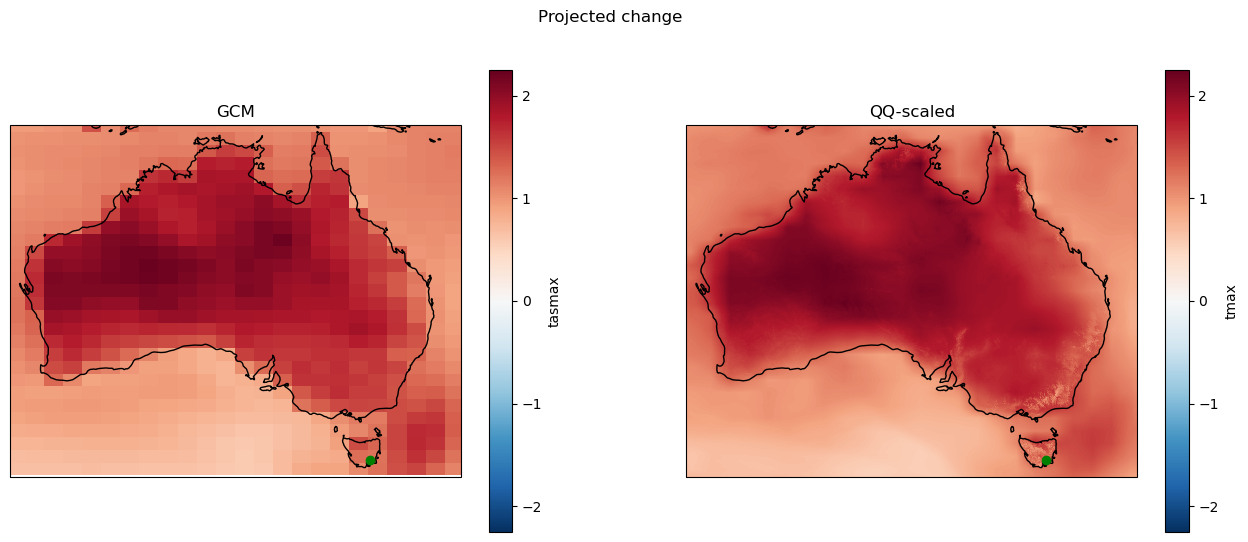

In [29]:
model_abs_max = np.max(np.abs(model_mean_change.sel(model_sel).values))
qq_abs_max = np.max(np.abs(qq_mean_change.values))
abs_max = np.max([model_abs_max, qq_abs_max])
vmax = abs_max
vmin = -1 * abs_max

fig = plt.figure(figsize=[16, 6])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
model_mean_change.sel(model_sel).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmax=vmax,
    vmin=vmin
)
ax1.set_title('GCM')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmax=vmax,
    vmin=vmin
)
ax2.set_title('QQ-scaled')

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.suptitle('Projected change')
plt.show()

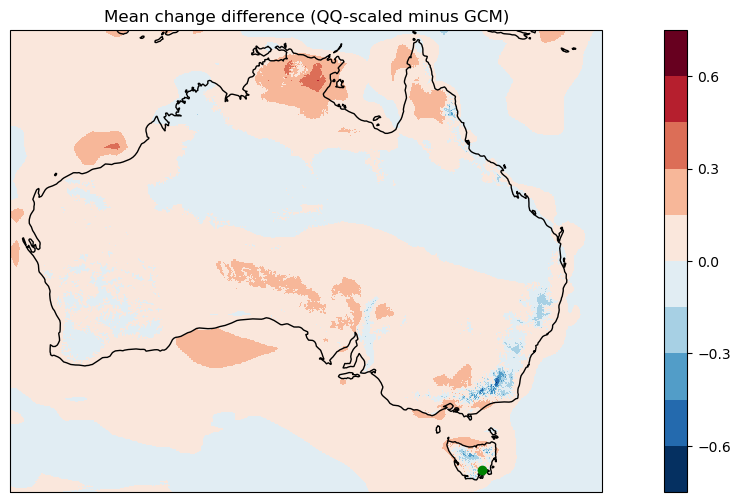

In [30]:
fig = plt.figure(figsize=[16, 6])

ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
mean_change_difference.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    levels=13,
)
ax1.set_title('Mean change difference (QQ-scaled minus GCM)')

ax1.coastlines()
ax1.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())

#plt.suptitle(f'{model_name}, {future_scenario} projected change')
plt.show()

[                                        ] | 0% Completed | 240.54 us

[                                        ] | 0% Completed | 107.96 ms

[                                        ] | 0% Completed | 209.34 ms

[                                        ] | 0% Completed | 310.66 ms

[                                        ] | 0% Completed | 411.97 ms

[                                        ] | 0% Completed | 513.34 ms

[                                        ] | 0% Completed | 614.72 ms

[                                        ] | 0% Completed | 716.06 ms

[                                        ] | 0% Completed | 817.44 ms

[                                        ] | 0% Completed | 918.82 ms

[                                        ] | 0% Completed | 1.02 s

[                                        ] | 0% Completed | 1.12 s

[                                        ] | 0% Completed | 1.22 s

[                                        ] | 0% Completed | 1.32 s

[                                        ] | 0% Completed | 1.43 s

[                                        ] | 0% Completed | 1.53 s

[                                        ] | 0% Completed | 1.63 s

[                                        ] | 0% Completed | 1.73 s

[                                        ] | 0% Completed | 1.83 s

[                                        ] | 0% Completed | 1.93 s

[                                        ] | 0% Completed | 2.03 s

[                                        ] | 0% Completed | 2.14 s

[                                        ] | 0% Completed | 2.24 s

[                                        ] | 0% Completed | 2.34 s

[                                        ] | 0% Completed | 2.44 s

[                                        ] | 0% Completed | 2.54 s

[                                        ] | 0% Completed | 2.64 s

[                                        ] | 0% Completed | 2.74 s

[                                        ] | 0% Completed | 2.84 s

[                                        ] | 0% Completed | 2.95 s

[                                        ] | 0% Completed | 3.05 s

[                                        ] | 0% Completed | 3.15 s

[                                        ] | 0% Completed | 3.25 s

[                                        ] | 0% Completed | 3.35 s

[                                        ] | 0% Completed | 3.45 s

[                                        ] | 0% Completed | 3.55 s

[                                        ] | 0% Completed | 3.66 s

[                                        ] | 0% Completed | 3.76 s

[                                        ] | 0% Completed | 3.86 s

[                                        ] | 0% Completed | 3.96 s

[                                        ] | 0% Completed | 4.06 s

[                                        ] | 0% Completed | 4.16 s

[                                        ] | 0% Completed | 4.26 s

[                                        ] | 0% Completed | 4.37 s

[                                        ] | 0% Completed | 4.47 s

[                                        ] | 0% Completed | 4.57 s

[                                        ] | 0% Completed | 4.67 s

[                                        ] | 0% Completed | 4.77 s

[                                        ] | 0% Completed | 4.87 s

[                                        ] | 0% Completed | 4.97 s

[                                        ] | 0% Completed | 5.07 s

[                                        ] | 0% Completed | 5.18 s

[                                        ] | 0% Completed | 5.28 s

[                                        ] | 0% Completed | 5.38 s

[                                        ] | 0% Completed | 5.48 s

[                                        ] | 0% Completed | 5.58 s

[                                        ] | 0% Completed | 5.68 s

[                                        ] | 0% Completed | 5.78 s

[####                                    ] | 11% Completed | 5.89 s

[###########                             ] | 28% Completed | 5.99 s

[##################                      ] | 46% Completed | 6.09 s

[#########################               ] | 63% Completed | 6.19 s

[################################        ] | 80% Completed | 6.30 s

[########################################] | 100% Completed | 6.40 s

[                                        ] | 0% Completed | 237.57 us

[                                        ] | 0% Completed | 108.07 ms

[                                        ] | 0% Completed | 209.35 ms

[                                        ] | 0% Completed | 310.64 ms

[                                        ] | 0% Completed | 412.01 ms

[                                        ] | 0% Completed | 513.39 ms

[                                        ] | 0% Completed | 614.80 ms

[                                        ] | 0% Completed | 718.31 ms

[                                        ] | 0% Completed | 819.72 ms

[                                        ] | 0% Completed | 921.09 ms

[                                        ] | 0% Completed | 1.02 s

[                                        ] | 0% Completed | 1.12 s

[                                        ] | 0% Completed | 1.23 s

[                                        ] | 0% Completed | 1.33 s

[                                        ] | 0% Completed | 1.43 s

[                                        ] | 0% Completed | 1.53 s

[                                        ] | 0% Completed | 1.63 s

[                                        ] | 0% Completed | 1.73 s

[                                        ] | 0% Completed | 1.83 s

[                                        ] | 0% Completed | 1.93 s

[                                        ] | 0% Completed | 2.04 s

[                                        ] | 0% Completed | 2.14 s

[                                        ] | 0% Completed | 2.24 s

[                                        ] | 0% Completed | 2.34 s

[                                        ] | 0% Completed | 2.44 s

[                                        ] | 0% Completed | 2.54 s

[                                        ] | 0% Completed | 2.64 s

[                                        ] | 0% Completed | 2.75 s

[                                        ] | 0% Completed | 2.85 s

[                                        ] | 0% Completed | 2.95 s

[                                        ] | 0% Completed | 3.05 s

[                                        ] | 0% Completed | 3.15 s

[                                        ] | 0% Completed | 3.25 s

[                                        ] | 0% Completed | 3.35 s

[                                        ] | 0% Completed | 3.46 s

[                                        ] | 0% Completed | 3.56 s

[                                        ] | 0% Completed | 3.66 s

[                                        ] | 0% Completed | 3.76 s

[                                        ] | 0% Completed | 3.86 s

[                                        ] | 0% Completed | 3.96 s

[                                        ] | 0% Completed | 4.06 s

[                                        ] | 0% Completed | 4.17 s

[                                        ] | 0% Completed | 4.27 s

[                                        ] | 0% Completed | 4.37 s

[                                        ] | 0% Completed | 4.47 s

[                                        ] | 0% Completed | 4.57 s

[                                        ] | 0% Completed | 4.67 s

[                                        ] | 0% Completed | 4.77 s

[                                        ] | 0% Completed | 4.87 s

[                                        ] | 0% Completed | 4.98 s

[                                        ] | 0% Completed | 5.08 s

[                                        ] | 0% Completed | 5.18 s

[                                        ] | 0% Completed | 5.28 s

[                                        ] | 0% Completed | 5.38 s

[                                        ] | 0% Completed | 5.48 s

[                                        ] | 0% Completed | 5.58 s

[                                        ] | 0% Completed | 5.69 s

[                                        ] | 0% Completed | 5.79 s

[                                        ] | 0% Completed | 5.89 s

[                                        ] | 0% Completed | 5.99 s

[                                        ] | 0% Completed | 6.09 s

[                                        ] | 0% Completed | 6.19 s

[                                        ] | 0% Completed | 6.29 s

[                                        ] | 0% Completed | 6.40 s

[                                        ] | 0% Completed | 6.50 s

[                                        ] | 0% Completed | 6.60 s

[                                        ] | 0% Completed | 6.70 s

[                                        ] | 0% Completed | 6.80 s

[                                        ] | 0% Completed | 6.90 s

[                                        ] | 0% Completed | 7.00 s

[                                        ] | 0% Completed | 7.11 s

[                                        ] | 0% Completed | 7.21 s

[                                        ] | 0% Completed | 7.31 s

[                                        ] | 0% Completed | 7.41 s

[                                        ] | 0% Completed | 7.51 s

[                                        ] | 0% Completed | 7.61 s

[                                        ] | 0% Completed | 7.71 s

[                                        ] | 0% Completed | 7.82 s

[                                        ] | 0% Completed | 7.92 s

[                                        ] | 0% Completed | 8.02 s

[                                        ] | 0% Completed | 8.12 s

[                                        ] | 0% Completed | 8.22 s

[                                        ] | 0% Completed | 8.32 s

[                                        ] | 0% Completed | 8.42 s

[#                                       ] | 3% Completed | 8.53 s

[########                                ] | 20% Completed | 8.63 s

[###############                         ] | 37% Completed | 8.73 s

[#####################                   ] | 54% Completed | 8.84 s

[############################            ] | 72% Completed | 8.94 s

[####################################    ] | 90% Completed | 9.04 s

[########################################] | 100% Completed | 9.14 s

[                                        ] | 0% Completed | 244.13 us

[####                                    ] | 11% Completed | 109.76 ms

[###########                             ] | 29% Completed | 212.16 ms

[##################                      ] | 47% Completed | 314.16 ms

[#########################               ] | 63% Completed | 415.68 ms

[################################        ] | 80% Completed | 517.82 ms

[########################################] | 100% Completed | 620.27 ms

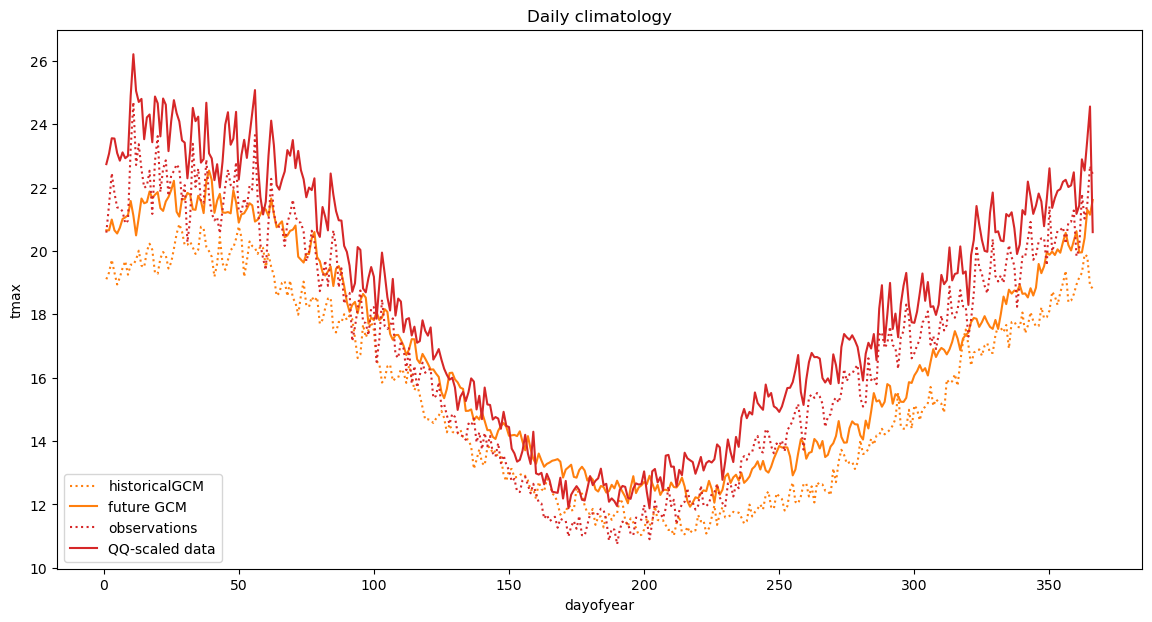

In [31]:
fig, ax = plt.subplots(figsize=[14, 7])
if 'lat' in qq_obs.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_hist[cmip_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="historicalGCM", color='tab:orange', linestyle=':')
ds_future[cmip_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="future GCM", color='tab:orange')
ds_obs[obs_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="observations", color='tab:red', linestyle=':')
qq_obs[obs_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="QQ-scaled data", color='tab:red')
plt.legend()
plt.title('Daily climatology')
plt.show()

[                                        ] | 0% Completed | 323.47 us

[########################################] | 100% Completed | 102.43 ms

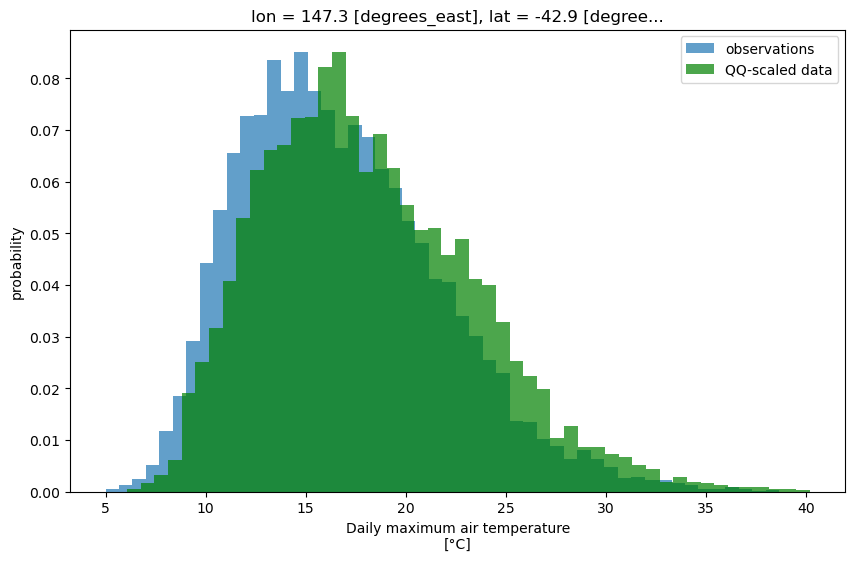

In [32]:
fig = plt.figure(figsize=[10, 6])
if 'lat' in qq_obs.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_obs[obs_var].sel(point_selection, method='nearest').plot.hist(bins=50, density=True, label='observations', alpha=0.7)
qq_obs[obs_var].sel(point_selection, method='nearest').plot.hist(bins=50, density=True, label='QQ-scaled data', facecolor='green', alpha=0.7)
plt.ylabel('probability')
plt.legend()
plt.show()